In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader import CryptoDataset, custom_collate_fn
from forecaster import MultiHorizonForecaster
from dataclasses import dataclass
from typing import List
from functions import plot_predictions
import numpy as np

In [2]:
class CryptoScaler:
    def __init__(self, crypto_stats, crypto_order):
        self.crypto_stats = crypto_stats  # Dict with mean/std per crypto
        self.crypto_order = crypto_order  # List of cryptos in channel order

    def inverse_transform(self, data):
        """Inverse scales data using stored crypto statistics."""
        rescaled = data.clone()
        for channel_idx, crypto in enumerate(self.crypto_order):
            mean = self.crypto_stats[crypto]['mean']
            std = self.crypto_stats[crypto]['std']
            rescaled[:, channel_idx, ...] = rescaled[:, channel_idx, ...] * std + mean
        return rescaled

training_dates = {
        'train_start': '2020-11-11',
        'train_end': '2024-05-31',
        'validation_start': '2024-06-01',
        'validation_end': '2024-12-31',
        'test_start': '2025-01-01',
        'test_end': '2025-01-14',
    }
batch_size = 1

test_dataset = CryptoDataset(
    file_path='data/combined_data.csv',
    lookback=28,
    horizon=14,
    date_attrs=['day_of_week', 'day_of_month', 'month', 'quarter', 'year_since_earliest_date'],
    crypto_data_features=['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'],
    date_ranges=training_dates,
    split="test",
    normalize="minmax",
)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#forecast_loader = DataLoader(forecast_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)


In [3]:
#for batch in forecast_loader:
#    print(batch)
    # print(f"Forecast Historical Data Shape: {batch['historical_data'].shape}")
    # print(f"Forecast Known Features Shape: {batch['known_features'].shape}")
    # print(f"Forecast Targets Shape: {batch['targets'].shape}")
    # print(f"Forecast Historical Date Ranges: {batch['historical_date_ranges']}")
    # print(f"Forecast Target Date Ranges: {batch['target_date_ranges']}")
    # break

In [3]:
@dataclass
class DataProps:
    num_historical_features: int
    num_time_features: int
    num_channels: int
    lookback: int
    horizon: int

@dataclass
class ModelConfig:
    output_quantiles: List[float]

@dataclass
class Config:
    data_props: DataProps
    model: ModelConfig


config = Config(
    data_props=DataProps(
        num_historical_features=6,
        num_time_features=5,
        num_channels=13,
        lookback=56,
        horizon=14
    ),
    model=ModelConfig(
        output_quantiles=[0.1, 0.5, 0.9],
    )
)
## load saved forecaster
forecaster = torch.load('forecaster_baseline.pth')

In [4]:
crypto_stats = forecaster.target_scaler.crypto_stats
train_config = forecaster.train_config
model_config = forecaster.config

In [5]:
crypto_stats

{'algorand': {'mean': Open          5.845619e-01
  High          6.126727e-01
  Low           5.570998e-01
  Close         5.845957e-01
  Volume        3.188993e+08
  Market Cap    3.034394e+09
  dtype: float64,
  'std': Open          5.341114e-01
  High          5.656515e-01
  Low           5.056099e-01
  Close         5.342374e-01
  Volume        4.148656e+08
  Market Cap    2.920070e+09
  dtype: float64,
  'min': Open          8.861785e-02
  High          9.034834e-02
  Low           8.459681e-02
  Close         8.840275e-02
  Volume        2.928619e+07
  Market Cap    2.994576e+08
  dtype: float64,
  'max': Open          2.384895e+00
  High          2.515728e+00
  Low           2.042196e+00
  Close         2.371276e+00
  Volume        6.383749e+09
  Market Cap    1.362386e+10
  dtype: float64},
 'avalanche': {'mean': Open          3.260182e+01
  High          3.420823e+01
  Low           3.110261e+01
  Close         3.263717e+01
  Volume        8.742357e+08
  Market Cap    8.625064

In [5]:
test_dataset = CryptoDataset(
        file_path=train_config['file_path'],
        lookback=model_config.data_props.lookback,
        horizon=model_config.data_props.horizon,
        date_attrs=train_config['date_attrs'],
        crypto_data_features=train_config['crypto_data_features'],
        date_ranges=train_config['training_dates'],
        split="validation",
        normalize="zscore",
        crypto_stats=crypto_stats,
    )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn)

# ## make predictions
# forecaster.eval()
# for batch in forecast_loader:
#     with torch.no_grad():
#         predictions = forecaster(batch)
#         print(predictions)
#         break

In [7]:
test_dataset.inverse_scale_targets

<bound method CryptoDataset.inverse_scale_targets of <dataloader.CryptoDataset object at 0x292f53970>>

In [6]:
for inputs in test_loader:
    #print(inputs)
    batch = {
        'historical_data': inputs['historical_data'],
        'time_features': inputs['date_features'],
        #'targets': inputs['targets'],
    }
    targets = inputs['targets']
    target_date_ranges = inputs['target_date_ranges']
    preds = forecaster.predict(batch)
    break
forecaster.predict(batch)
# targets = inputs['targets'].to(device)
# outputs = model(batch)

weights: torch.Size([13, 14, 3, 4])
torch.Size([1, 13, 14, 3])
torch.Size([1, 13, 14, 3])
weights: torch.Size([13, 14, 3, 4])
torch.Size([1, 13, 14, 3])
torch.Size([1, 13, 14, 3])


tensor([[[[-0.8687, -0.8553, -0.8464],
          [-0.8733, -0.8563, -0.8440],
          [-0.8767, -0.8565, -0.8416],
          [-0.8793, -0.8562, -0.8404],
          [-0.8843, -0.8555, -0.8395],
          [-0.8880, -0.8562, -0.8377],
          [-0.8913, -0.8567, -0.8369],
          [-0.8954, -0.8568, -0.8369],
          [-0.8964, -0.8577, -0.8359],
          [-0.8993, -0.8573, -0.8347],
          [-0.9017, -0.8576, -0.8344],
          [-0.9041, -0.8571, -0.8358],
          [-0.9059, -0.8573, -0.8342],
          [-0.9082, -0.8566, -0.8330]],

         [[-0.4096, -0.3828, -0.3406],
          [-0.4174, -0.3828, -0.3193],
          [-0.4252, -0.3829, -0.3050],
          [-0.4336, -0.3842, -0.2956],
          [-0.4410, -0.3852, -0.2833],
          [-0.4463, -0.3834, -0.2760],
          [-0.4478, -0.3874, -0.2695],
          [-0.4494, -0.3861, -0.2679],
          [-0.4511, -0.3885, -0.2549],
          [-0.4609, -0.3890, -0.2422],
          [-0.4684, -0.3912, -0.2393],
          [-0.4732, -0.

In [7]:
target_date_ranges

[[numpy.datetime64('2024-10-26T00:00:00.000000000'),
  numpy.datetime64('2024-10-27T00:00:00.000000000'),
  numpy.datetime64('2024-10-28T00:00:00.000000000'),
  numpy.datetime64('2024-10-29T00:00:00.000000000'),
  numpy.datetime64('2024-10-30T00:00:00.000000000'),
  numpy.datetime64('2024-10-31T00:00:00.000000000'),
  numpy.datetime64('2024-11-01T00:00:00.000000000'),
  numpy.datetime64('2024-11-02T00:00:00.000000000'),
  numpy.datetime64('2024-11-03T00:00:00.000000000'),
  numpy.datetime64('2024-11-04T00:00:00.000000000'),
  numpy.datetime64('2024-11-05T00:00:00.000000000'),
  numpy.datetime64('2024-11-06T00:00:00.000000000'),
  numpy.datetime64('2024-11-07T00:00:00.000000000'),
  numpy.datetime64('2024-11-08T00:00:00.000000000')]]

In [8]:
model_config.model.output_quantiles

[0.1, 0.5, 0.9]

In [11]:
test_dataset.inverse_scale_targets(preds, list(forecaster.crypto_to_index.keys()))

tensor([[[[3.4482e-01, 4.1390e-01, 4.3892e-01],
          [3.2174e-01, 4.0947e-01, 4.4758e-01],
          [3.0261e-01, 4.0761e-01, 4.5362e-01],
          [2.9028e-01, 4.0826e-01, 4.5554e-01],
          [2.6392e-01, 4.0654e-01, 4.5782e-01],
          [2.4386e-01, 4.0880e-01, 4.6021e-01],
          [2.2549e-01, 4.0505e-01, 4.6406e-01],
          [2.0551e-01, 4.0832e-01, 4.6282e-01],
          [2.0098e-01, 4.0190e-01, 4.6785e-01],
          [1.8477e-01, 4.0354e-01, 4.7130e-01],
          [1.7029e-01, 4.0298e-01, 4.6983e-01],
          [1.6032e-01, 4.0502e-01, 4.6599e-01],
          [1.4974e-01, 4.0422e-01, 4.6877e-01],
          [1.3720e-01, 4.0808e-01, 4.7481e-01]],

         [[4.1218e+01, 4.4856e+01, 4.6040e+01],
          [3.9821e+01, 4.4775e+01, 4.6544e+01],
          [3.9046e+01, 4.4635e+01, 4.6859e+01],
          [3.7615e+01, 4.4663e+01, 4.7099e+01],
          [3.6623e+01, 4.4607e+01, 4.7203e+01],
          [3.5986e+01, 4.4791e+01, 4.7529e+01],
          [3.5423e+01, 4.4344e+01, 4.7

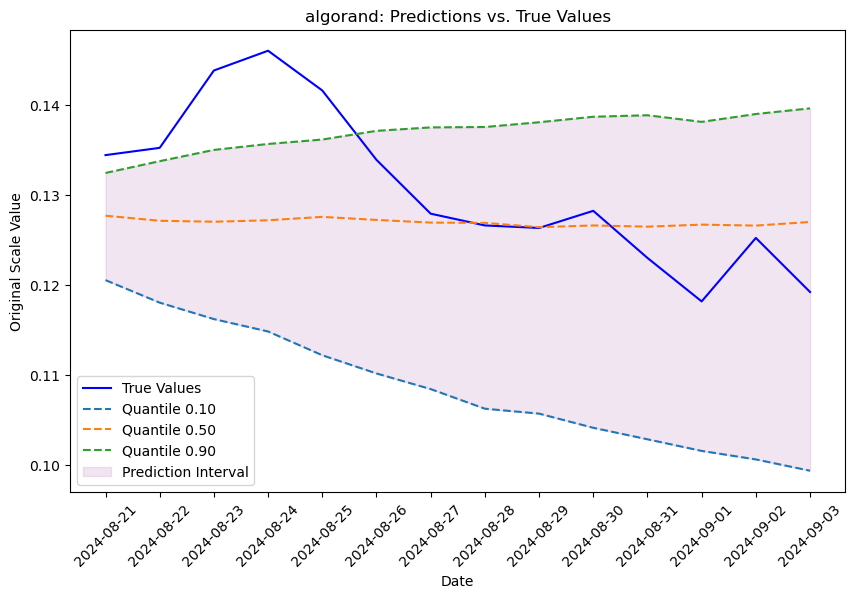

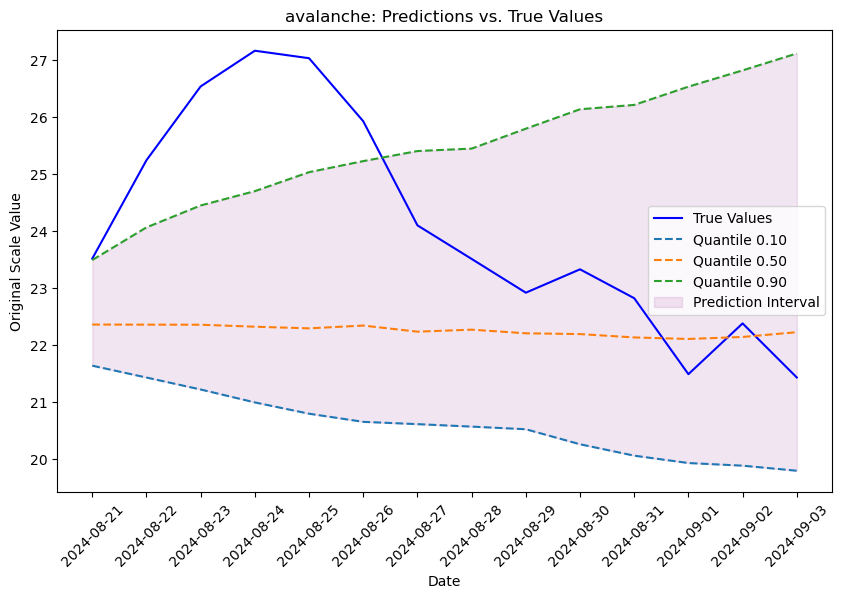

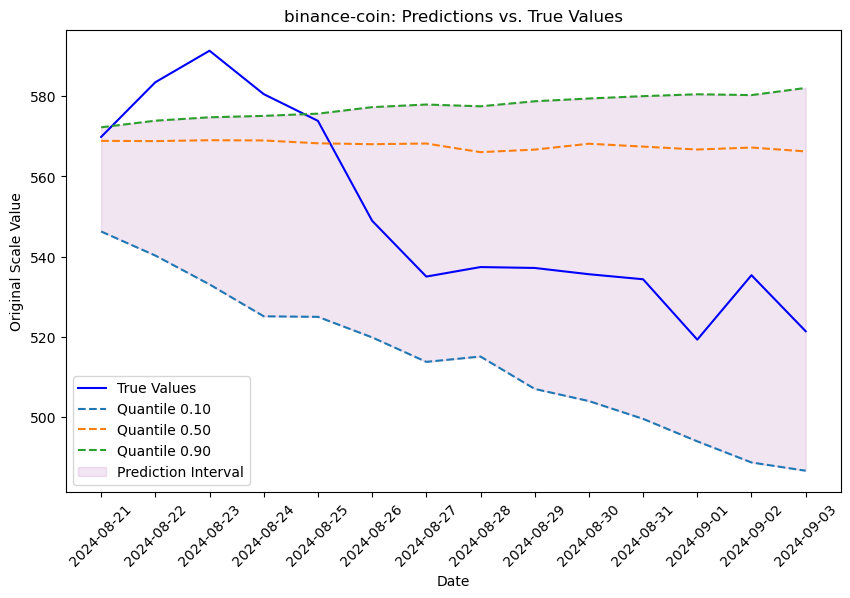

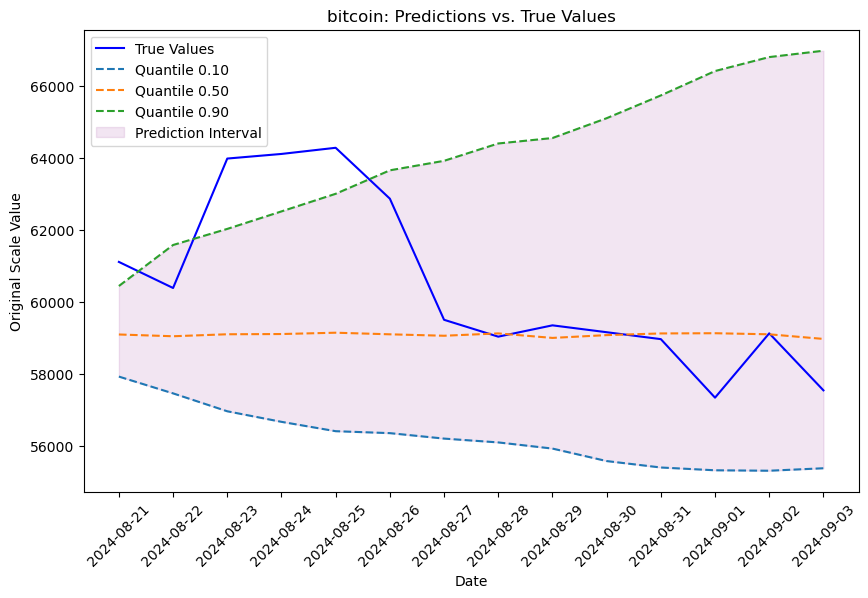

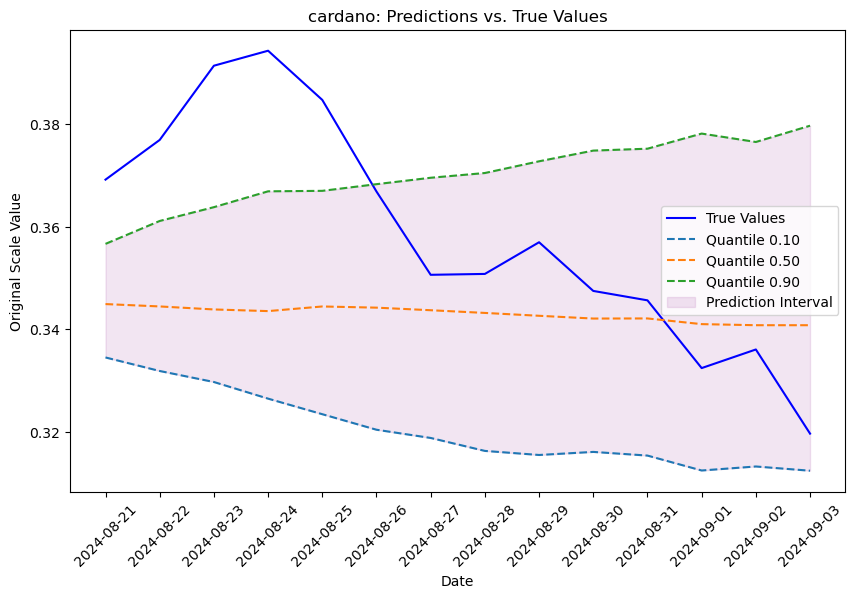

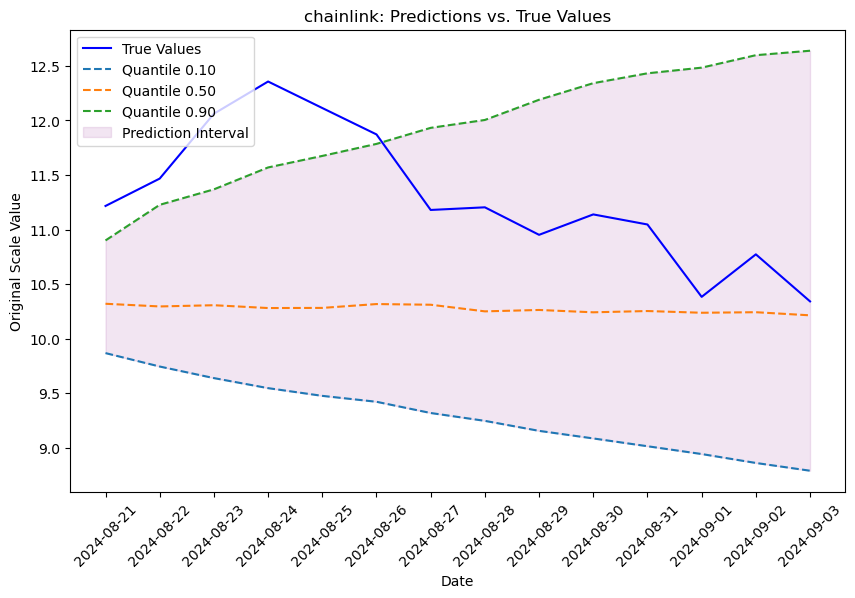

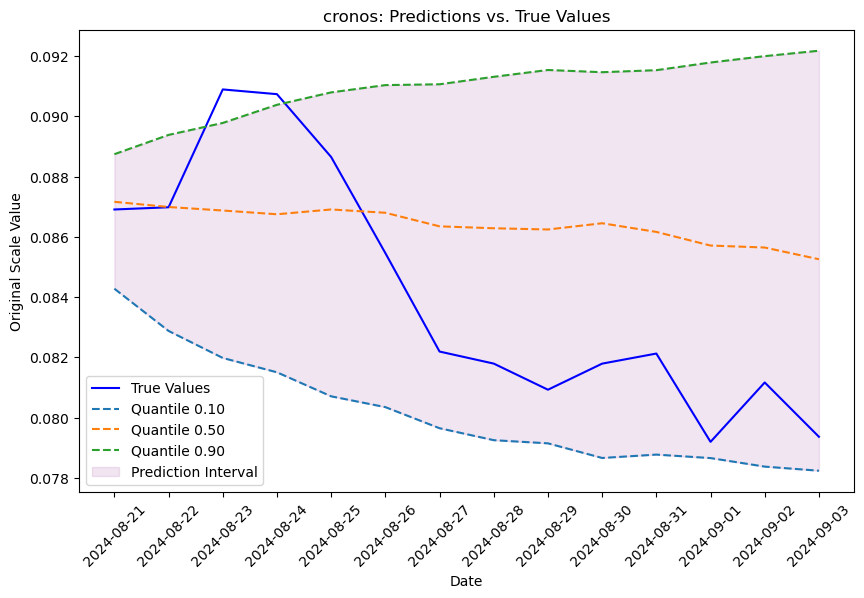

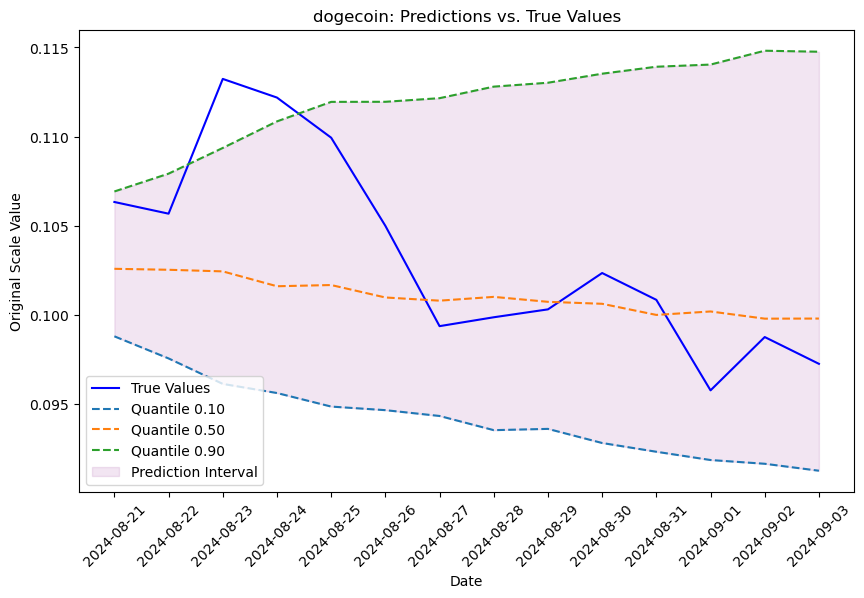

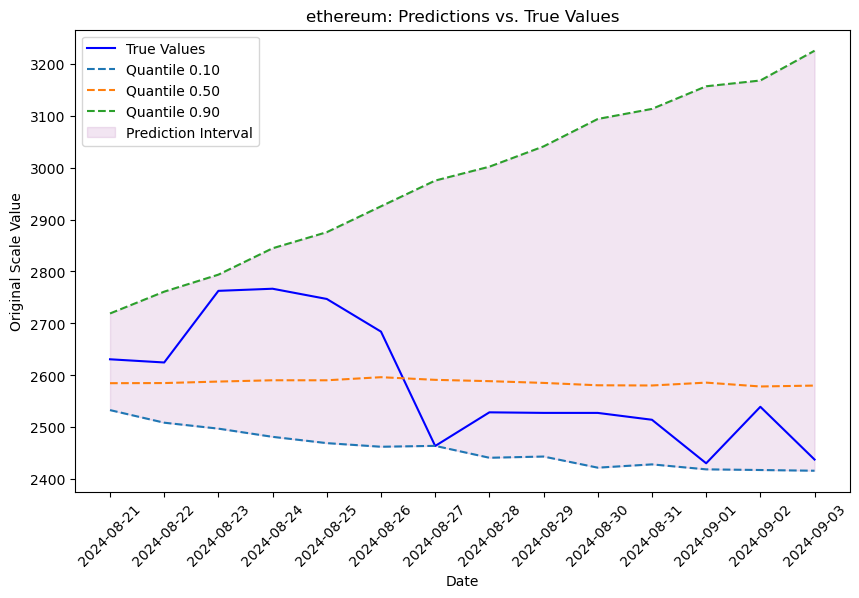

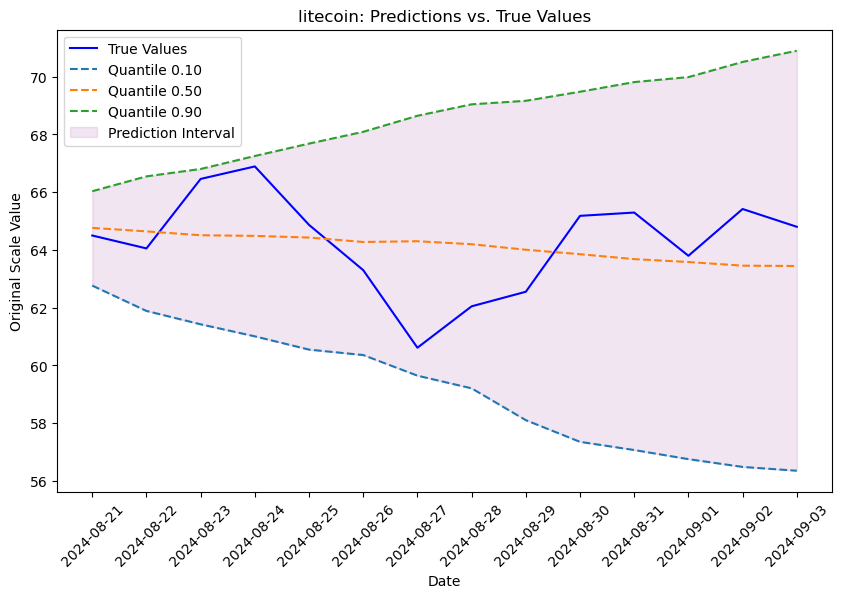

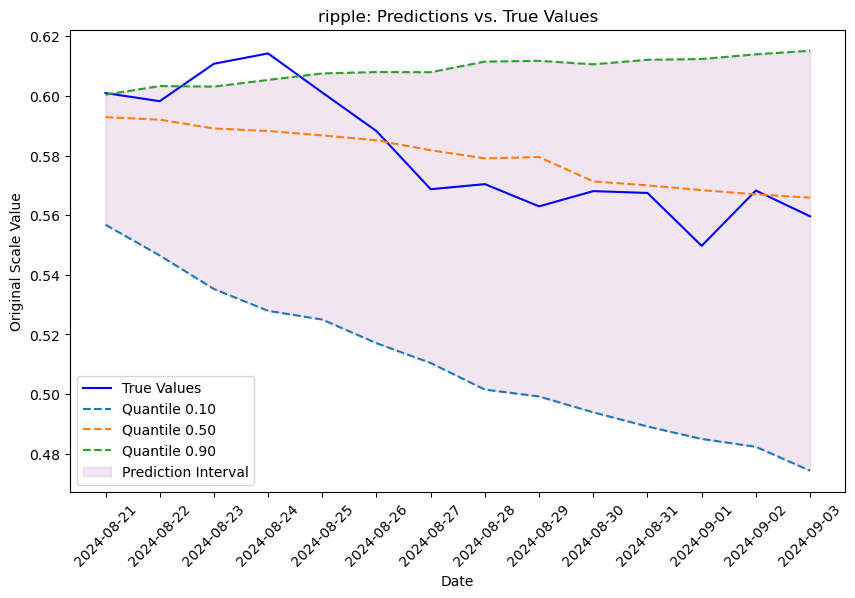

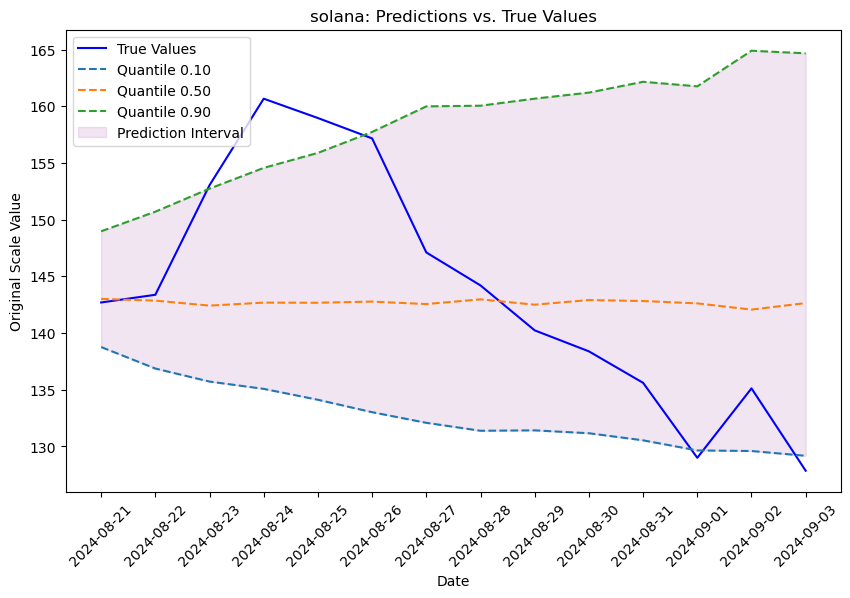

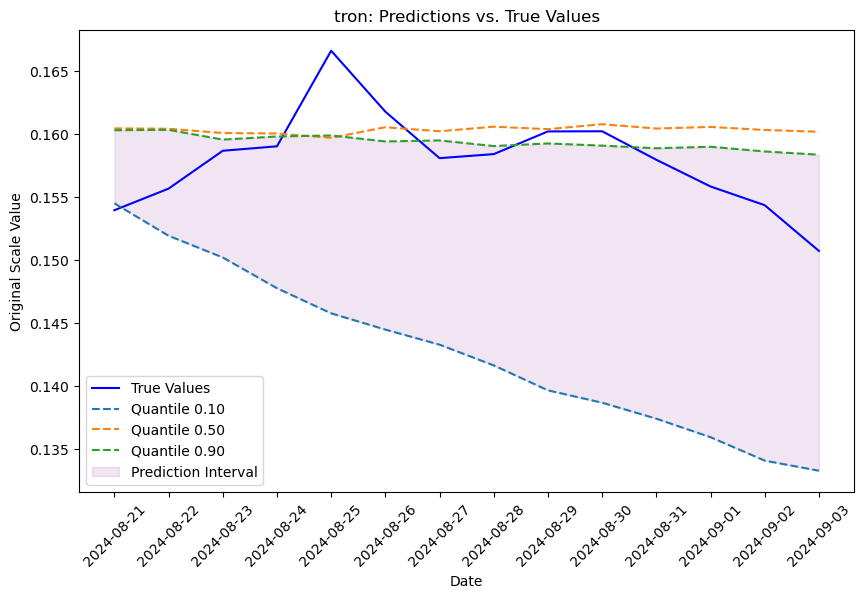

In [7]:
#preds
#batch['targets']
plot_predictions(
    preds.cpu(), 
    targets=targets.cpu(), 
    quantiles=model_config.model.output_quantiles, 
    target_date_ranges = np.array(target_date_ranges), 
    crypto_to_index=forecaster.crypto_to_index,
    target_scaler = test_dataset.inverse_scale_targets,
    forecast_mode=False
    )

#plot_predictions(batch['targets'], preds, model_config.model.output_quantiles, 'test')